In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import json
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

In [ ]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:16<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:07<00:00, 37.5MB/s]


In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

Archive:  /content/Dataset.zip
 extracting: Dataset/1644359422.816138.jpg  
  inflating: Dataset/1644359422.816138.json  
 extracting: Dataset/1644360063.82364.jpg  
  inflating: Dataset/1644360063.82364.json  
 extracting: Dataset/1644362482.7094185.jpg  
  inflating: Dataset/1644362482.7094185.json  
 extracting: Dataset/1644368971.6154966.jpg  
  inflating: Dataset/1644368971.6154966.json  
 extracting: Dataset/1644369207.922902.jpg  
  inflating: Dataset/1644369207.922902.json  
 extracting: Dataset/1644369658.7214494.jpg  
  inflating: Dataset/1644369658.7214494.json  
 extracting: Dataset/1644369774.9055796.jpg  
  inflating: Dataset/1644369774.9055796.json  
 extracting: Dataset/1644369801.9909956.jpg  
  inflating: Dataset/1644369801.9909956.json  
 extracting: Dataset/1644369842.0238864.jpg  
  inflating: Dataset/1644369842.0238864.json  
 extracting: Dataset/1644369905.2248352.jpg  
  inflating: Dataset/1644369905.2248352.json  
 extracting: Dataset/1644369972.1056488.jpg  
 

In [ ]:
img_name = "/content/Dataset/1644386314.3869328.jpg"
json_name = img_name[:-3] + "json"

In [ ]:
def best_box_crack(img_shapes):
  new_shapes = []
  for shape in img_shapes:
    points = np.array(shape['points'])
    points_x = []
    points_y = []
    for point in points:
      points_x.append(point[0])
      points_y.append(point[1])
    min_x , max_x = np.min(points_x), np.max(points_x)
    min_y , max_y = np.min(points_y), np.max(points_y)
    new_shapes.append([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])
  return(new_shapes) 

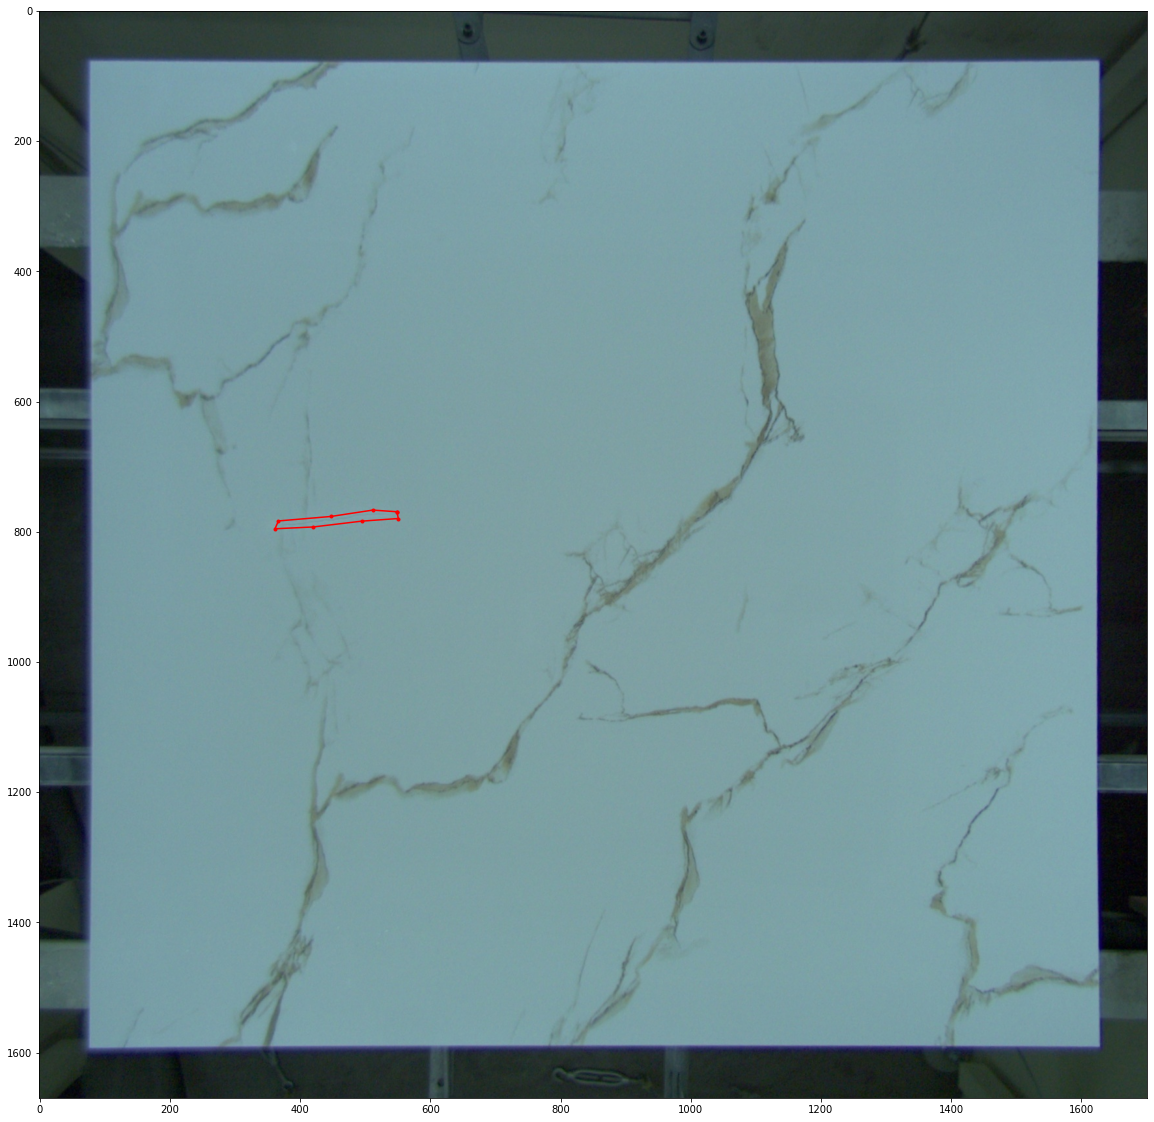

In [ ]:
img = cv.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

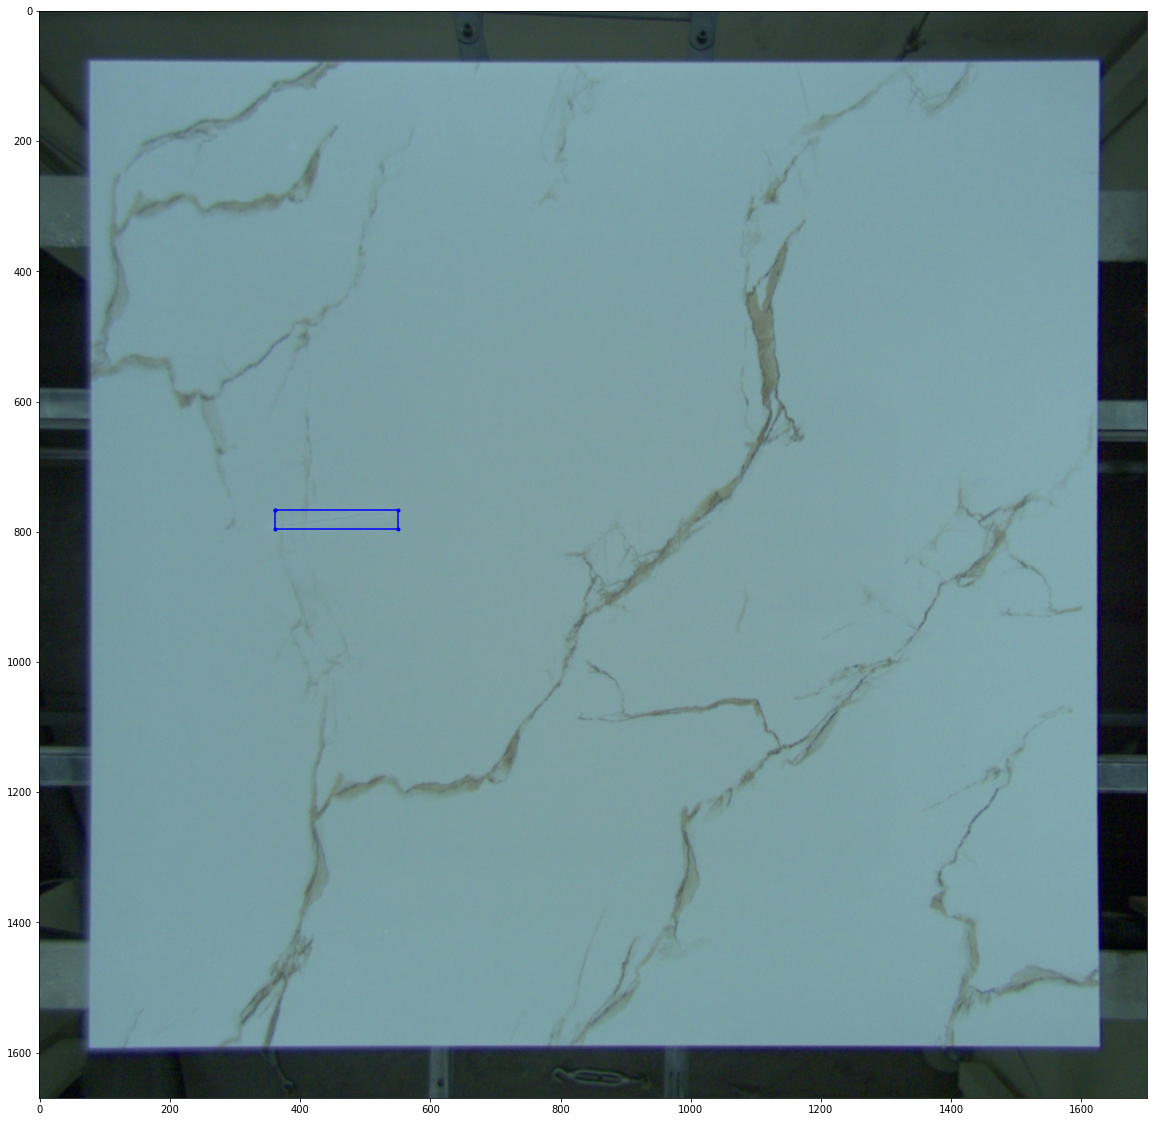

In [ ]:
img = cv.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])
new_shapes = best_box_crack(data["shapes"])
for shape in new_shapes:
  points = np.array(shape)
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'b.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

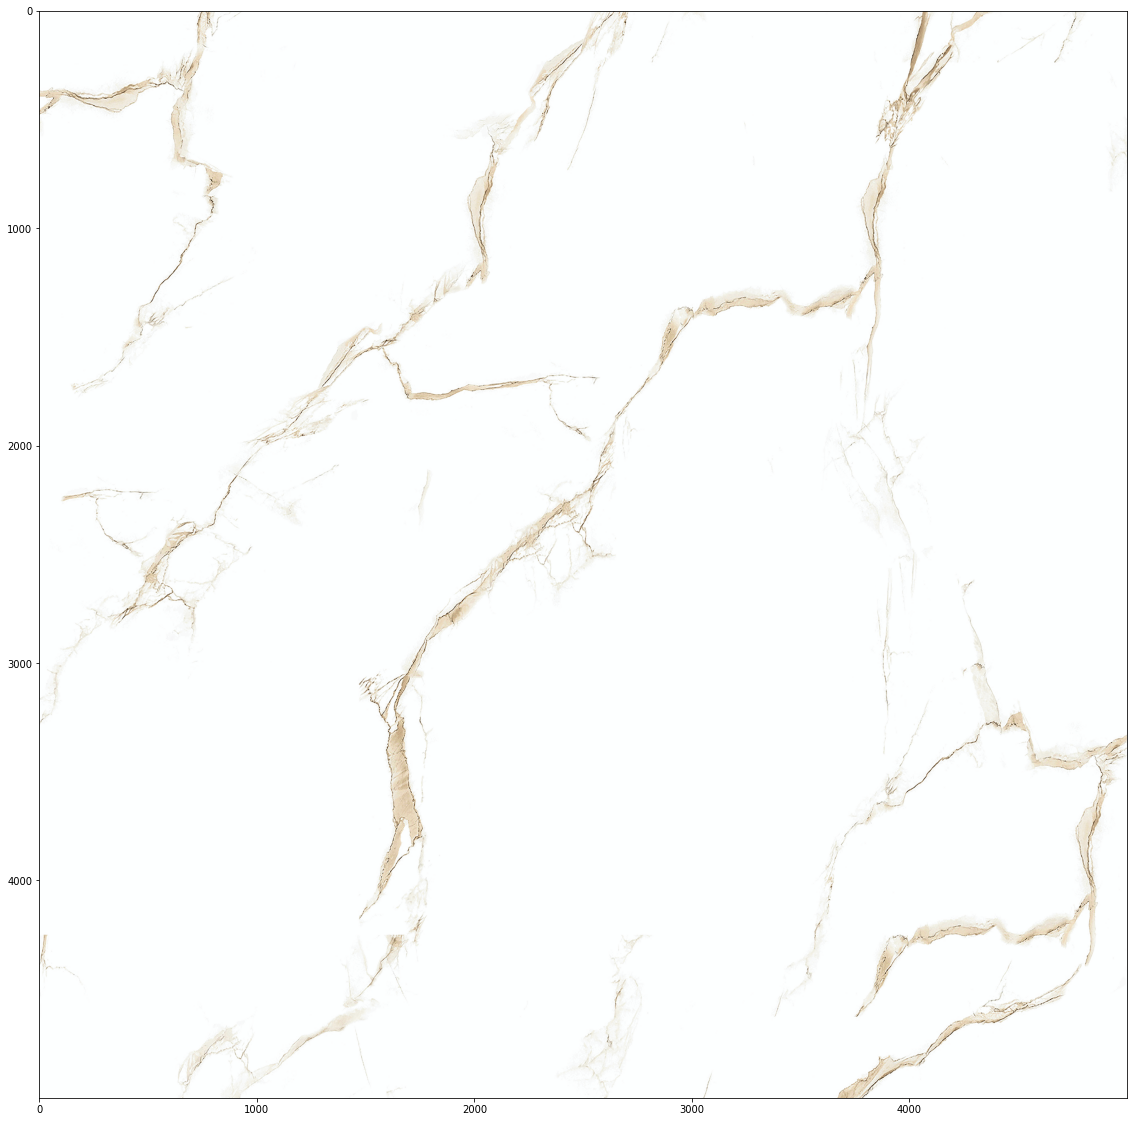

In [ ]:
pattern = cv.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])

In [ ]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [ ]:
def find_vertices(im, edges):
    Cont = np.zeros_like(im)
    # پیدا کردن خطوط برای لبه های شناسایی شده
    contours, hierarchy = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    # نگه داشتن تنها بزرگترین کانتور شناسایی شده.
    page = sorted(contours, key=cv.contourArea, reverse=True)[:5]
    Cont = cv.drawContours(Cont, page, -1, (0, 255, 255), 3)
    Cont = np.zeros_like(im)

    for p in page:
      # Approximate the contour.
      epsilon = 0.02 * cv.arcLength(p, True)
      corners = cv.approxPolyDP(p, epsilon, True)
      # اگر کانتور تقریبی ما چهار نقطه داشته باشد
      if len(corners) == 4:
          break
    cv.drawContours(Cont, p, -1, (0, 255, 255), 3)
    cv.drawContours(Cont, corners, -1, (0, 255, 0), 10)
    corners = sorted(np.concatenate(corners).tolist())

    return corners



In [ ]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

In [ ]:
def to_grayscale(im):
    # Your code goes here.
    img_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    return img_gray

In [ ]:
def blur(im):
    # Your code goes here.
    blur_image = cv.GaussianBlur(im, (11, 11), 0)
    return blur_image

In [ ]:
def to_edges(im):
    # Your code goes here.
    canny = cv.Canny(im, 0, 80)
    canny = cv.dilate(canny, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)))

    
    return canny

In [ ]:
def crop_out(im, vertices, pat, crack):
    pts = np.array(vertices)

    reorder_vertices =  reorder(np.float32(vertices))
    (tl, tr, br, bl) = pts
    tl[0] = (bl[0]+tl[0])/2
    tl[1] = (tl[1]+tr[1])/2
    tr[0] = (tr[0]+br[0])/2
    tr[1] = tl[1]
    br[0] = tr[0]
    br[1] = tr[1]
    bl[0] = tl[0]
    bl[1] = br[1]
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [pat.shape[0], 0], [pat.shape[1], pat.shape[1]], [0, pat.shape[1]]]
    new_cracks = []
    for shape in crack:
      to_add = []
      for p in shape:
        to_add.append([p[0], p[1], 1])
      new_cracks.append(to_add)


    # Getting the homography.
    transform_1 = cv.getPerspectiveTransform(np.float32(reorder_vertices), np.float32(destination_corners))


    # Perspective transform using homography.
    final = cv.warpPerspective(im, transform_1, (destination_corners[2][0], destination_corners[2][1]), flags=cv.INTER_LINEAR)

    print(transform_1.shape, np.array(new_cracks).T.shape)
    # new_cracks = np.matmul(transform_1, np.array(new_cracks).T)
    final_c = []
    for shape in new_cracks:
      to_add = []
      for p in shape:
        to_add.append(np.matmul(transform_1, np.array(p).T))
      final_c.append(to_add)
    final_cracks = []
    for shape in final_c:
      to_add = []
      for p in shape:
        to_add.append([p[0], p[1]])
      final_cracks.append(to_add)
    return final, final_cracks

In [ ]:
def scan(im, pat, new_shapes):
    grayscale = to_grayscale(im)
    blurred = blur(grayscale)
    edges = to_edges(blurred)
    vertices = find_vertices(img, edges)
    cropped = crop_out(im, vertices, pat, new_shapes)
    return cropped

(3, 3) (3, 4, 1)


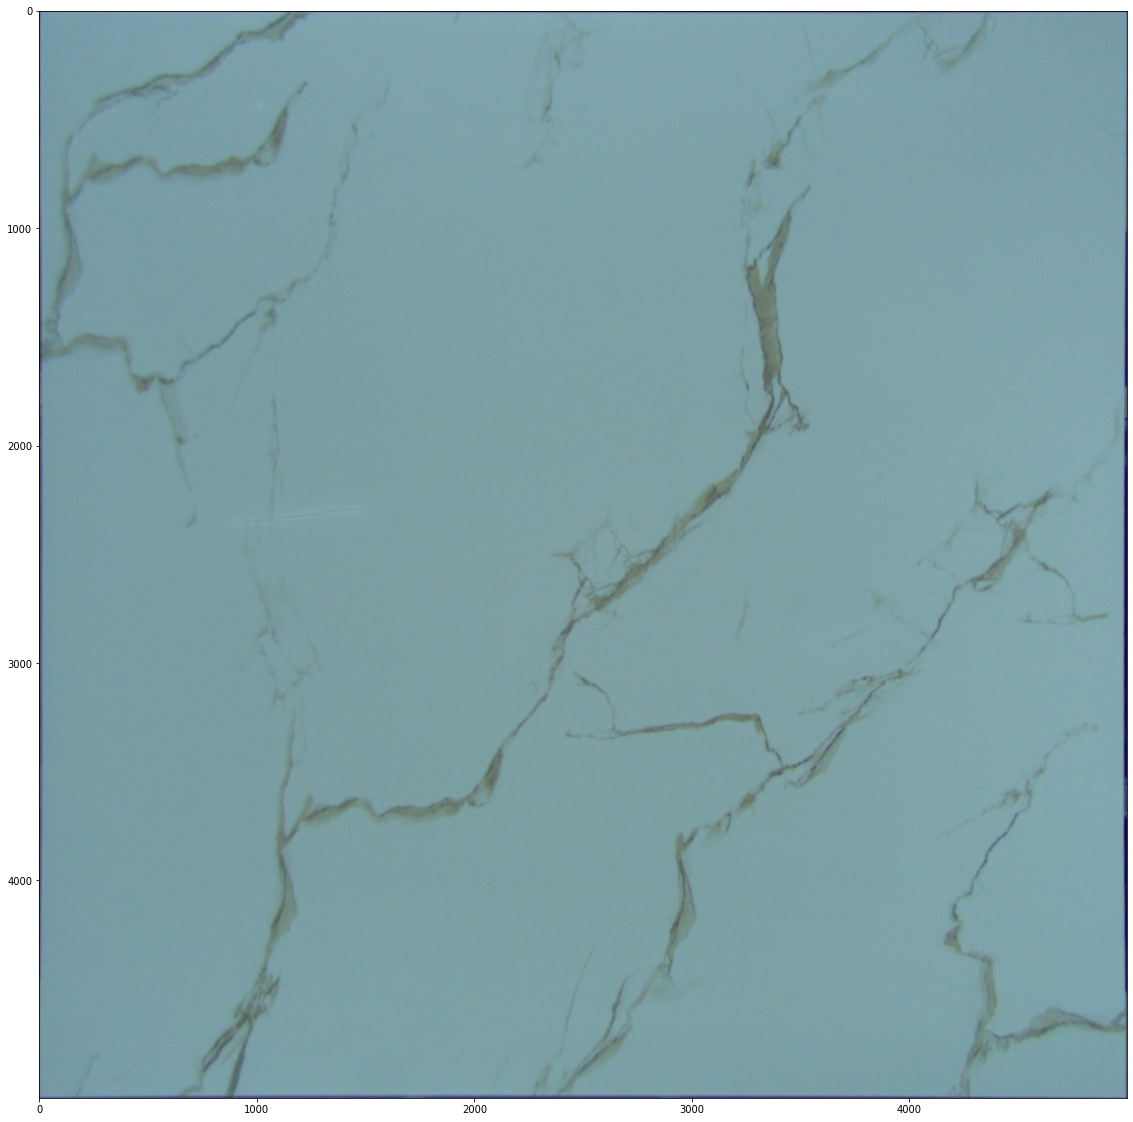

In [ ]:
cropped, t = scan(img, pattern, new_shapes)
plt.figure(figsize=(20, 20))
plt.imshow(cropped[..., ::-1])
# for shape in t:
#   points = np.array(shape)
#   ind = list(np.arange(points.shape[0])) + [0]
#   plt.plot(points[ind, 0], points[ind, 1], 'b.-')

In [ ]:
cropped_2 = cv.rotate(cropped, cv.ROTATE_90_COUNTERCLOCKWISE)
cropped_3 = cv.rotate(cropped_2, cv.ROTATE_90_COUNTERCLOCKWISE)
cropped_4 = cv.rotate(cropped_3, cv.ROTATE_90_COUNTERCLOCKWISE)

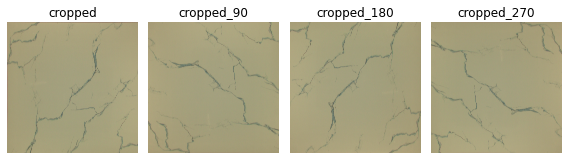

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, 
                                    ncols=4, 
                                    figsize=(8, 3),
                                    sharex=True, 
                                    sharey=True)
for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()
  
# displaying images
ax1.imshow(cropped)
ax1.set_title('cropped')
ax2.imshow(cropped_2[15:-15,15:-15,:])
ax2.set_title('cropped_90')
ax3.imshow(cropped_3[15:-15,15:-15,:])
ax3.set_title('cropped_180')
ax4.imshow(cropped_4[15:-15,15:-15,:])
ax4.set_title('cropped_270')

plt.tight_layout()
plt.show()

In [ ]:
def histogram_matching(cropped, pattern):
  matched = match_histograms(cropped, pattern, 
                           multichannel=True,)
  return matched


In [ ]:
histo_1 =  histogram_matching(cropped, pattern)[15:-15,15:-15,:]
histo_2 =  histogram_matching(cropped_2, pattern)[15:-15,15:-15,:]
histo_3 =  histogram_matching(cropped_3, pattern)[15:-15,15:-15,:]
histo_4 =  histogram_matching(cropped_4, pattern)[15:-15,15:-15,:]

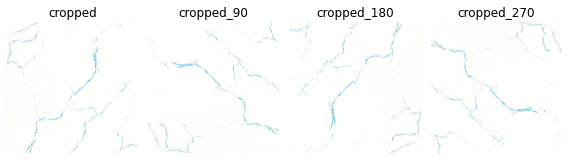

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, 
                                    ncols=4, 
                                    figsize=(8, 3),
                                    sharex=True, 
                                    sharey=True)
for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()
  
# displaying images
ax1.imshow(histo_1)
ax1.set_title('cropped')
ax2.imshow(histo_2[15:-15,15:-15,:])
ax2.set_title('cropped_90')
ax3.imshow(histo_3[15:-15,15:-15,:])
ax3.set_title('cropped_180')
ax4.imshow(histo_4[15:-15,15:-15,:])
ax4.set_title('cropped_270')

plt.tight_layout()
plt.show()

In [ ]:
binary_1 = to_binary(histo_1)
binary_2 = to_binary(histo_2)
binary_3 = to_binary(histo_3) 
binary_4 = to_binary(histo_4)

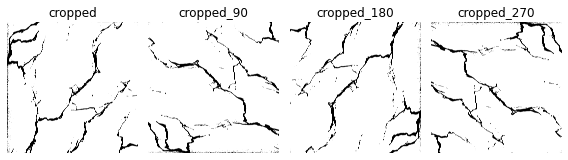

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, 
                                    ncols=4, 
                                    figsize=(8, 3),
                                    sharex=True, 
                                    sharey=True)
for aa in (ax1, ax2, ax3, ax4):
    aa.set_axis_off()
  
# displaying images
ax1.imshow(binary_1, cmap='gray')
ax1.set_title('cropped')
ax2.imshow(binary_2[15:-15,15:-15], cmap='gray')
ax2.set_title('cropped_90')
ax3.imshow(binary_3[15:-15,15:-15], cmap='gray')
ax3.set_title('cropped_180')
ax4.imshow(binary_4[15:-15,15:-15], cmap='gray')
ax4.set_title('cropped_270')

plt.tight_layout()
plt.show()

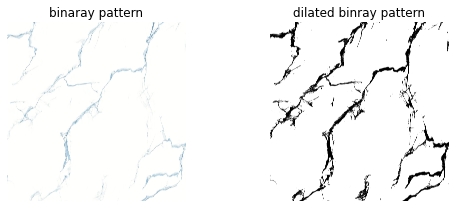

In [ ]:
pattern = pattern[15:-15,15:-15,:]
binary_pattern = to_binary(pattern)

# apply dilation on pattern
dilated_pattern = dilation(binary_pattern)

fig, (ax1, ax2) = plt.subplots(nrows=1, 
                                    ncols=2, 
                                    figsize=(8, 3),
                                    sharex=True, 
                                    sharey=True)
for aa in (ax1, ax2):
    aa.set_axis_off()
  
# displaying images
ax1.imshow(pattern, cmap='gray')
ax1.set_title('binaray pattern')
ax2.imshow(binary_pattern[15:-15,15:-15], cmap='gray')
ax2.set_title('dilated binray pattern')

plt.tight_layout()
plt.show()

In [ ]:
def find_matchest(inputs, pattern):
  matchest = 0
  index = 0
  for i in range(len(inputs)):
    mul = np.multiply(inputs[i], pattern)
    sum = np.sum(mul)
    if sum>matchest: 
      matchest = sum
      index = i
  print(matchest)
  return inputs[index]


1282031


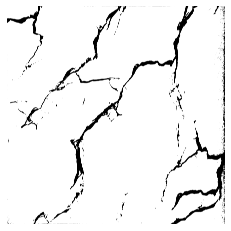

In [ ]:
all_input_to_check = [cv.bitwise_not(binary_1), cv.bitwise_not(binary_2), cv.bitwise_not(binary_3), cv.bitwise_not(binary_4)]
matchest = find_matchest(all_input_to_check, cv.bitwise_not(dilated_pattern))
matchest = cv.bitwise_not(matchest)

imshow(matchest)

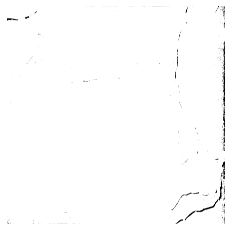

In [ ]:
cleaned = clean_the_image(matchest, dilated_pattern)
imshow(cleaned)

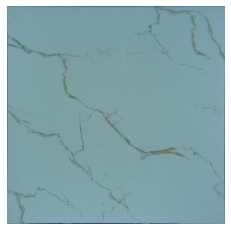

In [ ]:
inputs = [cropped, cropped_2, cropped_3, cropped_4]
matchest = find_matchest(inputs, pattern)
imshow(matchest)

In [ ]:
def to_binary(img):
  gray_img = to_grayscale(img)
  blur = cv.GaussianBlur(gray_img,(5,5),0)
  ret,thresh = cv.threshold(blur,250,255, 0)
  return thresh

In [ ]:
def dilation(img):
  # define the kernel
  kernel = np.ones((40, 40), np.uint8)
    
  # invert the image
  invert = cv.bitwise_not(img)
    
  # dilate the image
  dilation = cv.dilate(invert, kernel, iterations=1)
  
  dilated = cv.bitwise_not(dilation)
  return(dilated)

In [ ]:
def clean_the_image(img, pattern):
  for i in range(pattern.shape[0]):
    for j in range(pattern.shape[1]):
      if pattern[i][j]==0:
        img[i][j]=255
  return img

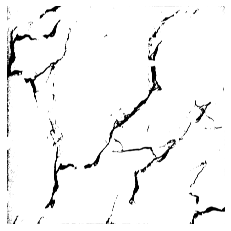

In [ ]:
res = clean_the_image(matched_binary, pattern_dilated)
imshow(res)

In [ ]:
# imshow(dilation)

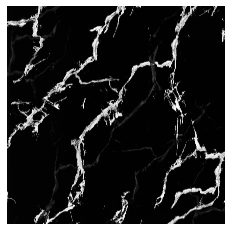

In [ ]:
imshow(-(to_grayscale(matched[15:-15,15:-15,:])-to_grayscale(pattern[15:-15,15:-15,:]))+1)

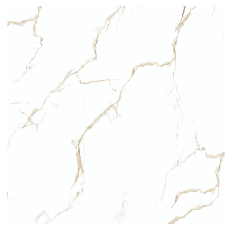

In [ ]:
imshow(pattern[15:-15,15:-15,:])

In [ ]:
def preprosess(img, pattern, crack):

  # cropping the picture
  cropped = scan(img, pattern, crack)
  
  # rotate picture 4 times(each time 90 degree)
  cropped_2 = cv.rotate(cropped, cv.ROTATE_90_COUNTERCLOCKWISE)
  cropped_3 = cv.rotate(cropped_2, cv.ROTATE_90_COUNTERCLOCKWISE)
  cropped_4 = cv.rotate(cropped_3, cv.ROTATE_90_COUNTERCLOCKWISE)

  # histogram matching for each one
  histo_1 =  histogram_matching(cropped, pattern)[15:-15,15:-15,:]
  histo_2 =  histogram_matching(cropped_2, pattern)[15:-15,15:-15,:]
  histo_3 =  histogram_matching(cropped_3, pattern)[15:-15,15:-15,:]
  histo_4 =  histogram_matching(cropped_4, pattern)[15:-15,15:-15,:]

  # convert all to binary
  binary_1 = to_binary(histo_1)
  binary_2 = to_binary(histo_2)
  binary_3 = to_binary(histo_3) 
  binary_4 = to_binary(histo_4)

  # convert pattern to binary
  pattern = pattern[15:-15,15:-15,:]
  binary_pattern = to_binary(pattern)

  # apply dilation on pattern
  dilated_pattern = dilation(binary_pattern)
  

  # find matchest img to pattern 
  all_input_to_check = [cv.bitwise_not(binary_1), cv.bitwise_not(binary_2), cv.bitwise_not(binary_3), cv.bitwise_not(binary_4)]
  matchest = find_matchest(all_input_to_check, cv.bitwise_not(dilated_pattern))
  matchest = cv.bitwise_not(matchest)

  imshow(matchest)
  # remove the pattern from image
  cleaned = clean_the_image(matchest, dilated_pattern)
  return (matchest, dilated_pattern)
  # imshow(cleaned)

In [ ]:
def make_model_data(img, pattern, new_shapes):
  cropped, t = scan(img, pattern, new_shapes)
  plt.figure(figsize=(20, 20))
  plt.imshow(cropped[..., ::-1])
  for shape in t:
    points = np.array(shape)
    ind = list(np.arange(points.shape[0])) + [0]
    plt.plot(points[ind, 0], points[ind, 1], 'b.-')
  return [cropped, t]

(3, 3) (3, 4, 1)


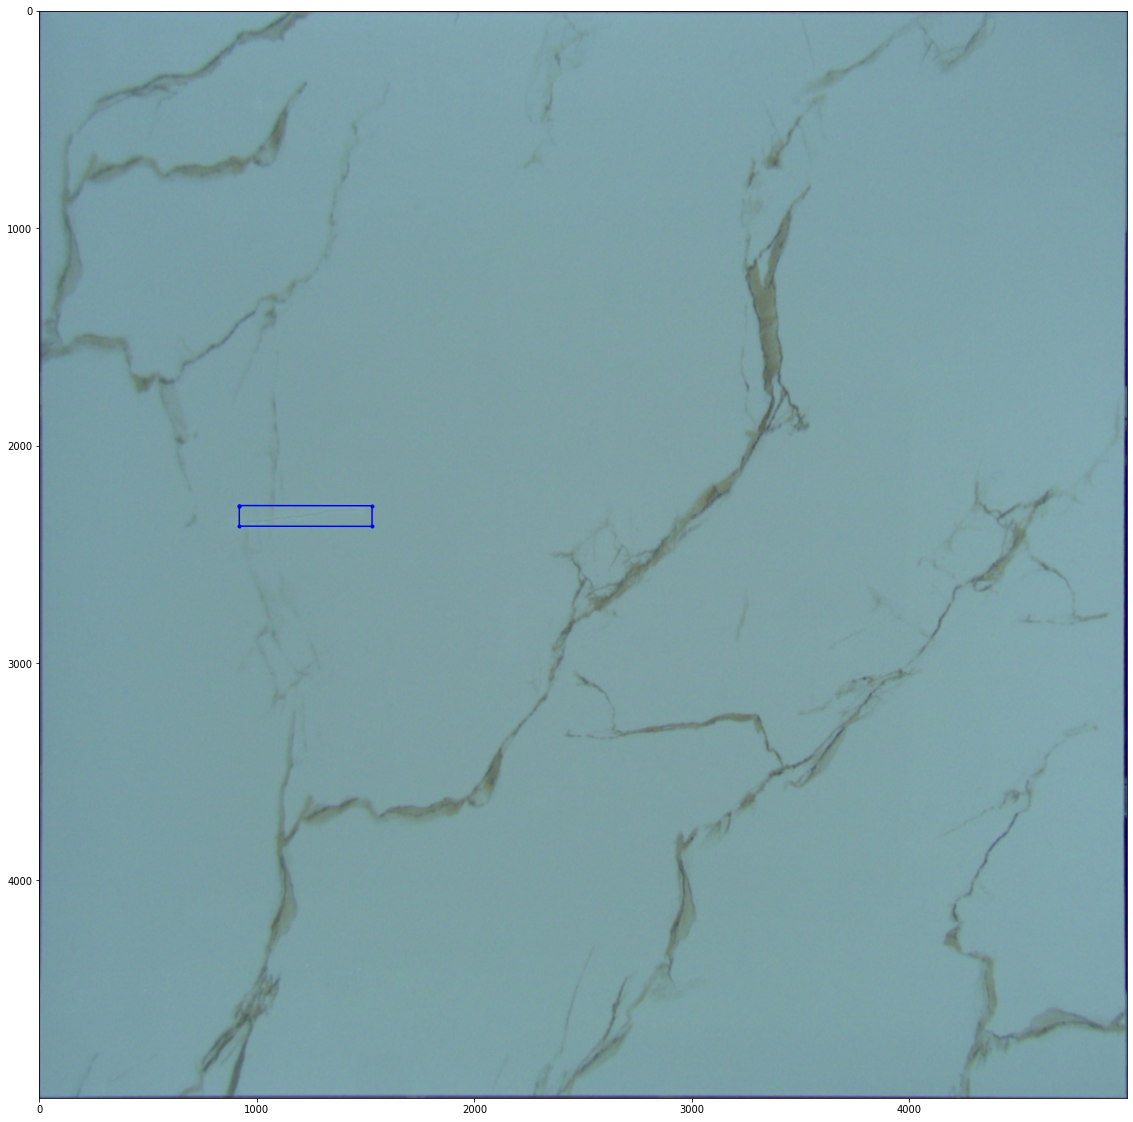

In [ ]:
model_img, model_cracks = make_model_data(img, pattern, new_shapes)

In [ ]:
# m, d = preprosess(img, pattern, new_shapes)

In [ ]:
# imshow(m)

In [ ]:
# imshow(d)

In [ ]:
# preprosess(img, pattern, new_shapes)

Model

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print(device, torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print(device)

cpu


In [ ]:
#input
img0 = model_img.copy()


In [ ]:
#bounding box
print(model_cracks)
boxes1 = np.array(model_cracks)
labels = np.array([1,1])

[[[919.201069695738, 2275.828646963104], [919.201069695738, 2370.6209446650937], [1529.6832556395552, 2371.4278995911063], [1529.6832556395552, 2276.6356018891165]]]


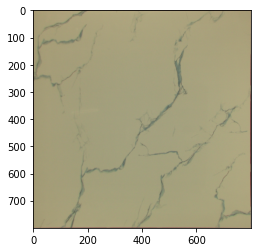

In [ ]:
#resize
img_r = cv.resize(img0, dsize = (800, 800), interpolation = cv.INTER_CUBIC)
plt.imshow(img_r)

In [ ]:
#coordinate bounding box
w_scale = 800/img0.shape[0]
h_scale = 800/img0.shape[1]


In [ ]:
boxes = []
for points in boxes1:
  h = []
  x0 = points[0][0]
  y0 = points[0][1]

  x1 = points[1][0]
  y1 = points[1][1]

  x2 = points[2][0]
  y2 = points[2][1]

  x3 = points[3][0]
  y3 = points[3][1]

  xmin = int(w_scale * np.min([x0, x1, x2, x3]))
  ymin = int(w_scale * np.min([y0, y1, y2, y3]))
  xmax = int(h_scale * np.max([x0, x1, x2, x3]))
  ymax = int(w_scale * np.max([y0, y1, y2, y3]))
  h = [xmin, ymin, xmax, ymax]
  boxes.append(h.copy())
boxes = np.array(boxes)
print(boxes)



[[147 364 244 379]]


VGG16 to extract features

In [ ]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fc = list(model.features)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
d_img = torch.zeros((1, 3, 800, 800)).float()
req_features = []
k = d_img.clone().to(device)
out_channels=0
for i in fc:
  k = i(k)
  if k.size()[2] < 800//16:
    break
  req_features.append(i)
  out_channels = k.size()[1]
  


Convert this list to sequential models

In [ ]:
faster_rcnn_fc_extractor = nn.Sequential(*req_features)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img_r).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fc_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


In [ ]:
print(len(req_features))
print(out_channels)

30
512


Visualize

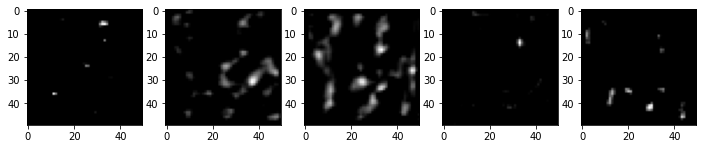

In [ ]:
imArr = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
  fig.add_subplot(1,5,figNo)
  plt.imshow(imArr[i], cmap="gray")
  figNo += 1
plt.show()

generate anchor box

In [ ]:
fc_size = 800//16
ctr_x = np.arange(16, (fc_size+1) * 16, 16)
ctr_y = np.arange(16, (fc_size+1) * 16, 16)

In [ ]:
indx = 0
ctr = np.zeros((2500,2))
for x in range(len(ctr_x)):
  for y in range(len(ctr_y)):
    ctr[indx, 1] = ctr_x[x] - 8
    ctr[indx, 0] = ctr_y[y] - 8
    indx += 1
print(ctr.shape)

(2500, 2)


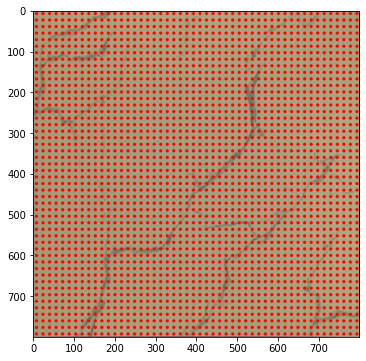

In [ ]:
img_clone = np.copy(img_r)
plt.figure(figsize=(9,6))
for i in range(ctr.shape[0]):
  cv.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius = 1, color = (255, 0, 0), thickness =5)
plt.imshow(img_clone)
plt.show()

In [ ]:
rations = [0.25, 0.5, 1]
scales = [4, 8, 16]
sub_samples = 16
anchor_boxes = np.zeros( ((fc_size * fc_size *9), 4))
indx = 0
for c in ctr:
  ctr_y, ctr_x = c
  for i in range(len(rations)):
    for j in range(len(scales)):
      h = sub_samples * scales[j] * np.sqrt(rations[i])
      w = sub_samples * scales[j] * np.sqrt(1/rations[i])
      anchor_boxes[indx, 0] = ctr_y - h / 2
      anchor_boxes[indx, 1] = ctr_x - w / 2
      anchor_boxes[indx, 2] = ctr_y + h / 2
      anchor_boxes[indx, 3] = ctr_y + w / 2
      indx += 1
print(anchor_boxes.shape)

(22500, 4)


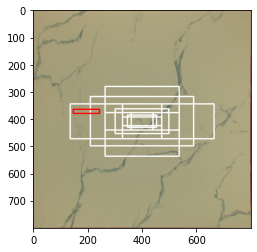

In [ ]:
img_clone = np.copy(img_r)
# plt.imshow(img_clone)
for i in range(11025, 11034):
  x0 = int(anchor_boxes[i][1])
  y0 = int(anchor_boxes[i][0])
  x1 = int(anchor_boxes[i][3])
  y1 = int(anchor_boxes[i][2])
  # plt.plot(boxes[ind, 0], boxes[ind, 1], 'r.-')
  cv.rectangle(img_clone, (x0, y0), (x1, y1), color = (255, 255, 2550), thickness = 3)
# for shape in data["shapes"]:
#   points = np.array(shape['points'])
#   ind = list(np.arange(points.shape[0])) + [0]
#   plt.plot(points[ind, 0], points[ind, 1], 'r.-')

for shape in boxes:
  points = np.array(shape)
  xmin = points[0]
  ymin = points[1]
  xmax = points[2]
  ymax = points[3]

  cv.rectangle(img_clone, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color = (255, 0, 0), thickness = 3)
plt.imshow(img_clone)
plt.show()

validation anchor boxes with ground truth boxes by IOU 

In [ ]:
index_inside = np.where(
    (anchor_boxes[:,0] >= 0) &
    (anchor_boxes[:,1] >= 0) &
    (anchor_boxes[:,2] <= 800) &
    (anchor_boxes[:,3] <= 800) 
)[0]
print(index_inside.shape)
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes)

(15591,)
[[  8.         8.        72.        72.      ]
 [ 24.         8.        88.        88.      ]
 [ 40.         8.       104.       104.      ]
 ...
 [721.372583 746.745166 766.627417 789.254834]
 [712.       760.       776.       776.      ]
 [728.       760.       792.       792.      ]]


In [ ]:
def get_iou(crack, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(crack[0], pred[0])
    iy1 = np.maximum(crack[1], pred[1])
    ix2 = np.minimum(crack[2], pred[2])
    iy2 = np.minimum(crack[3], pred[3])
     
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
     
    area_of_intersection = i_height * i_width
     
    # Ground Truth dimensions.
    gt_height = crack[3] - crack[1] + 1
    gt_width = crack[2] - crack[0] + 1
     
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
     
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
     
    iou = area_of_intersection / area_of_union
     
    return iou

In [ ]:
#calculate IOU
#٫منبع:https://www.youtube.com/watch?v=4yOcsWg-7g8


ious = np.empty((len(valid_anchor_boxes), 2), dtype = np.float32)
ious.fill(0)
pos_thresh = 0.7
neg_thresh = 0.3
for num1 , i in enumerate(valid_anchor_boxes):
  ya1, xa1, ya2, xa2 = i
  c = [ya1, xa1, ya2, xa2]
  for num2, j in enumerate(boxes):
    yb1, xb1, yb2, xb2 = i
    p = [yb1, xb1, yb2, xb2]
    iou = get_iou(c, p)
    ious[num1, num2] = iou
print(ious.shape)


(15591, 2)


In [ ]:
#what anchor box has max iou with the ground truth box
gt_arg_max_ious = ious.argmax(axis = 0)
print(gt_arg_max_ious)

gt_max_ious = ious[gt_arg_max_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_arg_max_ious = np.where(ious == gt_max_ious)[0]
print(gt_arg_max_ious)

[0 0]
[1. 0.]
[    0     0     1 ... 15589 15590 15590]


In [ ]:
#what ground truth box is associate with cach anchor box
arg_max_ious = ious.argmax(axis = 1)
print(arg_max_ious.shape)
print(arg_max_ious)

max_ious = ious[np.arange(len(index_inside)), arg_max_ious]
print(max_ious)


(15591,)
[0 0 0 ... 0 0 0]
[1. 1. 1. ... 1. 1. 1.]


valid anchor box
1: object
0:background

In [ ]:
label = np.empty((len(index_inside), ),dtype = np.int32)
label.fill(-1)
print(label.shape)

(15591,)


In [ ]:
# using iou to assign 0 and 1 to anchors
pos_iou_tresh = 0.7
neg_iou_tresh = 0.3
label[gt_arg_max_ious] = 1
label[max_ious >= pos_iou_tresh] = 1
label[max_ious < neg_iou_tresh] = 0
print(label)

[1 1 1 ... 1 1 1]


Mini-Batch Training: 256

In [ ]:
n_sample = 256
pos_ratio = 0.5
n_pos = int(pos_ratio * n_sample)

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
  disable_indx = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace = False)
  label[disable_indx] = -1

n_neg = int(n_sample * np.sum(label == 1))

neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
  disable_indx = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
  label[disable_indx] = -1

In [ ]:
max_iou_bbox = np.array(boxes)[arg_max_ious]
print(max_iou_bbox.shape)
print(max_iou_bbox[0])

height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 2] + 0.5 * width
print(valid_anchor_boxes.shape)
print(valid_anchor_boxes[0])
#valid anchor box
busc_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
busc_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
busc_ctr_y = max_iou_bbox[:, 0] + 0.5 * busc_height
busc_ctr_x = max_iou_bbox[:, 1] + 0.5 * busc_width


eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

print(busc_ctr_y[0])
print(ctr_y[0])

dy = (busc_ctr_y - ctr_y)/height
dx = (busc_ctr_x - ctr_x)/width
dh = np.log(busc_height/height)
dv = np.log(busc_width/width)
anchor_locs = np.vstack((dy, dx, dh, dv)).transpose()
print(anchor_locs.shape)


(15591, 4)
[147 364 244 379]
(15591, 4)
[ 8.  8. 72. 72.]
195.5
40.0
(15591, 4)


In [ ]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)


anchor_location = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=max_iou_bbox.dtype)
anchor_location.fill(0)
anchor_location[index_inside, :] = anchor_locs
print(anchor_location.shape)

(22500,)
(22500, 4)


Region Proposal Network(ROIs):

In [ ]:
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor*4, 1,1,0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor*2, 1,1,0).to(device) #softmax
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
x = conv1(out_map.to(device))
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [ ]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
# pred_anchor_locs = pred_anchor_locs.permute(0, 2, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)
objectness_scores = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1]
print(objectness_scores.shape)
pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 50, 50, 9])
torch.Size([1, 22500, 2])


RPN 22500 ROIs

In [ ]:
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)
print(anchor_location.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [ ]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_location)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [ ]:
#classification
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index=-1)
print(rpn_cls_loss)

tensor(0.6976, grad_fn=<NllLossBackward0>)


In [ ]:
#regression
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)


mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)


x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([128, 4]) torch.Size([128, 4])
tensor(1.1124e+18, grad_fn=<SumBackward0>)


In [ ]:
#combineing
rpn_lambda = 10
N_reg = (gt_rpn_score> 0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(8.6905e+16, grad_fn=<AddBackward0>)


NMS(Non-maximum supression)

In [ ]:
nms_tresh = 0.7
n_train_prc_num = 308
n_train_post_nums = 308
n_test_prc_num = 60
n_test_prc_num = 60
min_size = 16

In [ ]:
#change format of anchor
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

#change format of labels predicate
pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_scores[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]

print(dy.shape)

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [ ]:
#RFN
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype = anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)


img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [ ]:
#remove predicate boxes
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 2] - roi[:, 0]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy.reshape((22500,))[keep]
print(keep.shape, roi.shape, score.shape)

#sort
order = score.ravel().argsort()[::-1]
print(order.shape)

#take top pre_nums
order = order[:n_train_prc_num]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)


(22500,) (22500, 4) (22500,)
(22500,)
(308,) (308, 4) (308, 4)


In [ ]:
#take all the roi boxes
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]

#find the areas of all boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [ ]:
order = order.argsort()[::-1]
keep = []
while(order.size > 0):
  i = order[0]
  keep.append(i)
  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])
  w = np.maximum(0.0, xx2-xx1+1)
  h = np.maximum(0.0, yy2-yy1+1)
  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_tresh)[0]
  order = order[inds + 1]
keep = keep[:n_train_post_nums]
roi = roi[keep]
print(len(keep), roi.shape)

228 (228, 4)


In [ ]:
n_sample = 128
pos_ratio = 1
n_pos = int(pos_ratio * n_sample)
pos_iou_tresh = 0.9
neg_iou_tresh_hi = 0.6
neg_iou_tresh_lo = 0.0

In [ ]:
#find the iou each ground truth object with the regopn
ious = np.empty((len(valid_anchor_boxes), 2), dtype = np.float32)
ious.fill(0)

for num1 , i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  c = [ya1, xa1, ya2, xa2]
  for num2, j in enumerate(boxes):
    yb1, xb1, yb2, xb2 = i
    p = [yb1, xb1, yb2, xb2]
    iou = get_iou(c, p)
    ious[num1, num2] = iou
print(ious.shape)

(15591, 2)


In [ ]:
gt_assignment = ious.argmax(axis = 1)
print(gt_assignment)

max_iou = ious.max(axis = 1)
print(max_iou)

gt_roi_label = label > gt_assignment
print(gt_roi_label)

[0 0 0 ... 0 0 0]
[1. 1. 1. ... 0. 0. 0.]
[False False False ... False False False]


In [ ]:
pos_roi_per_imag = 32
pos_index = np.where(max_iou >= pos_iou_tresh)[0]
pos_roi_per_this_imag = int(min(pos_roi_per_imag, pos_index.size))
if pos_index.size > 0:
  pos_index = np.random.choice(pos_index, size=pos_roi_per_this_imag , replace = False)

print(pos_roi_per_this_imag)
print(pos_index)

neg_index = np.where((max_iou < neg_iou_tresh_hi) & (max_iou >= neg_iou_tresh_lo))[0]
neg_roi_per_this_imag = n_sample - pos_roi_per_imag
neg_roi_per_this_imag = int(min(neg_roi_per_this_imag, neg_index.size))
if neg_index.size > 0:
  neg_index = np.random.choice(neg_index, size=neg_roi_per_this_imag , replace = False)
print(neg_roi_per_this_imag)
print(neg_index)


32
[127 213 144 143  96 178 179 211 161 225 141 182 212 209 147 223 207 171
 156 133 169 180   5 138  82 208  88 131  50  49 165  91]
96
[11667 14614   581  6934  8799 12927  7041  5059  9498 12588 12260   357
  3700  6129  7706 13988  3763 13410  8477   826   922  1389 11362 10366
  1707  6196  1773  7495  1538  9008  1546  4559  3049 13330  3246  2638
  1650  3553 14252 14175  7691 14019 13399  7873 14588 14705  8316  2936
  3797 11998  6890 14014  3051  3313 14049  1579 13809  4797 11991 15216
 11298 12492  1909   339  2902  6594  4105 11221 10029  4460  4494 11222
  6971  5922  7867   536  2475  9926 10278  3925 14095 15094  3804 11243
  1679 12243 14479  7552  9834  7342  4558 15521   302  2768  1204 13501]


display roi samples

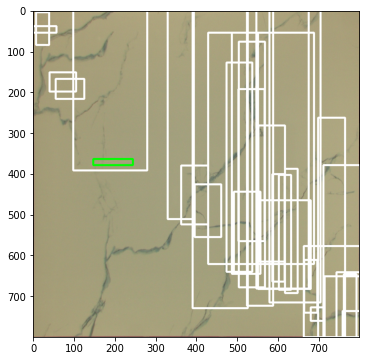

In [ ]:
img_clone = np.copy(img_r)
plt.figure(figsize=(9,6))
for i in range(pos_roi_per_this_imag):
  x0, y0, x1, y1 = roi[pos_index[i]].astype(int)
  cv.rectangle(img_clone, (x0, y0), (x1, y1), color = (255, 255, 255), thickness = 3)
for i in range(len(boxes)):
  cv.rectangle(img_clone, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color = (0, 255, 0), thickness = 3)
plt.imshow(img_clone)
plt.show()

228


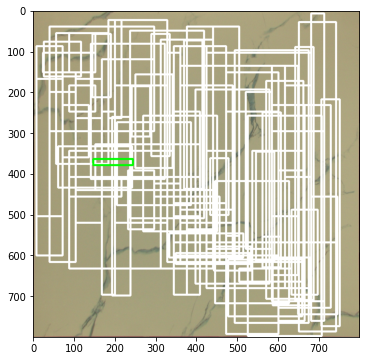

In [ ]:
img_clone = np.copy(img_r)
plt.figure(figsize=(9,6))
print(len(roi))
for i in range(neg_roi_per_this_imag):
  x0, y0, x1, y1 = valid_anchor_boxes[neg_index[i]].astype(int)
  cv.rectangle(img_clone, (x0, y0), (x1, y1), color = (255, 255, 255), thickness = 3)
for i in range(len(boxes)):
  cv.rectangle(img_clone, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color = (0, 255, 0), thickness = 3)
plt.imshow(img_clone)
plt.show()

In [ ]:
#gather positive samples
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_imag:] = 0
sample_roi = valid_anchor_boxes[keep_index]
print(sample_roi.shape)


box_for_sampled_roi = boxes[gt_assignment[keep_index]]
print(box_for_sampled_roi.shape)
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y  = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width



busc_height = box_for_sampled_roi[:, 2] - box_for_sampled_roi[:, 0]
busc_width = box_for_sampled_roi[:, 3] - box_for_sampled_roi[:, 1]
busc_ctr_y = box_for_sampled_roi[:, 0] + 0.5 * busc_height
busc_ctr_x = box_for_sampled_roi[:, 1] + 0.5 * busc_width

(128, 4)
(128, 4)


In [ ]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)


dy = (busc_ctr_y - ctr_y)/height
dx = (busc_ctr_x - ctr_x)/width
dh = np.log(busc_height/height)
dv = np.log(busc_width/width)


gt_roi_locs = np.vstack((dy, dx, dh, dv)).transpose()
print(gt_roi_locs.shape)

(128, 4)


ROI Pooling

In [ ]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois), ), dtype = np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)
indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [ ]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])


In [ ]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0)
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size)

<built-in method size of Tensor object at 0x7fc2bda10b30>


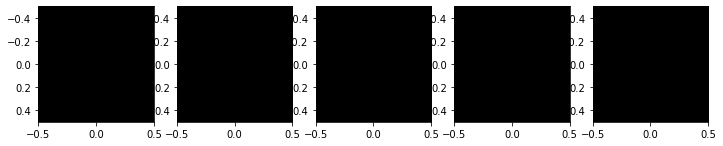

In [ ]:
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
  roi = rois[i]
  im_idx = roi[0]
  im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
  tmp = im[0][0].detach().cpu().numpy()
  fig.add_subplot(1,5,figNo)
  plt.imshow(tmp, cmap="gray")
  figNo += 1
plt.show()

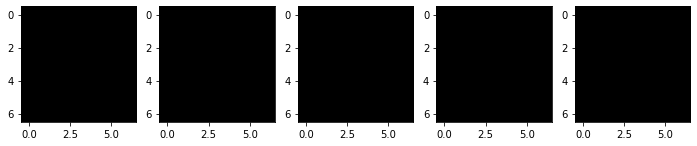

In [ ]:
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
  roi = rois[i]
  im_idx = roi[0]
  im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
  tmp = adaptive_max_pool(im)[0]
  tmp = tmp[0][0].detach().cpu().numpy()
  fig.add_subplot(1,5,figNo)
  plt.imshow(tmp, cmap="gray")
  figNo += 1
plt.show()

In [ ]:
k = output.view(output.size(0), -1)
print(k.shape)

torch.Size([128, 25088])


In [ ]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)

In [ ]:
cls_loc = nn.Linear(4096, 2* 4).to(device)
cls_loc.weight.data.normal_(0, 0.1)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device)

In [ ]:
#pass output to roi head
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [ ]:
#predict
gt_roi_labels

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False]